# Modelling Customer Churn 3 - Modelling and Explaining the Data

## A. P. Young

### 2022-04-03

In [1]:
import time
START = time.time()
import datetime
from datetime import timedelta
import os
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import shap

# Introduction

We want to model and understand the reasons behind customer churn. **Customer churn** refers to when customers have voluntarily stopped using a business' services within a given time window, usually expressed as a rate or a percentage. Usually, it is more expensive for businesses to acquire new customers than keep existing customers. Therefore, measuring, modelling and understanding customer churn is important for businesses, especially in industries where churn rate is high (e.g. mobile phones, insurance, internet service providers... etc.)

For more details, see https://www.investopedia.com/terms/c/churnrate.asp (last accessed 3/4/2022)

The dataset is from Kaggle - https://www.kaggle.com/datasets/blastchar/telco-customer-churn (last accessed 2/4/2022).

As an overview of this notebook, we get the cleaned dataset, address multicollinearity and balance the churn classes (either by upsampling or downsampling), train five models and adjust their hyperparameters on this data, and take the most accurate model and use SHAP to explain which features are most influentual. This is motivated by two questions (mentioned in a previous notebook):

  1. How can we accurately model customer churn?
  
  2. What are the important features that one should consider for customer retention?
  
**N.B.** The times measured below are obtained by running this notebook locally on a 2017-purchased Macbook Air.

## Get Data

We get the data - the data has already been cleaned (i.e. every value is numerical, and there are no missing values) in the preceding notebook.

In [2]:
data = pd.read_csv('customer_churn_cleaned.csv')

In [3]:
data.shape

(7043, 26)

In [4]:
data

,is_female,SeniorCitizen,Partner,Dependents,tenure/month,PhoneService,MultipleLines,internet_service_is_dsl,internet_service_is_fiber_optic,OnlineSecurity,...,Contract_is_one_year,Contract_is_two_year,PaperlessBilling,PaymentMethod_is_electronic_check,PaymentMethod_is_mailed_check,PaymentMethod_is_bank_transfer,PaymentMethod_is_credit_card,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,0,1,0,0,...,0,0,1,1,0,0,0,29.85,29.85,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,56.95,1889.50,0
2,0,0,0,0,2,1,0,1,0,1,...,0,0,1,0,1,0,0,53.85,108.15,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,0,1,0,42.30,1840.75,0
4,1,0,0,0,2,1,0,0,1,0,...,0,0,1,1,0,0,0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,1,0,1,...,1,0,1,0,1,0,0,84.80,1990.50,0
7039,1,0,1,1,72,1,1,0,1,0,...,1,0,1,0,0,0,1,103.20,7362.90,0
7040,1,0,1,1,11,0,0,1,0,1,...,0,0,1,1,0,0,0,29.60,346.45,0
7041,0,1,1,0,4,1,1,0,1,0,...,0,0,1,0,1,0,0,74.40,306.60,1


## Address Multicollinearity

In a previous notebook, when we had a look at the distributions and input feature correlations, we have two recommendations:

  1. Balance the classes of `Churn` to be predicted, either by downsampling the majority class or upsampling the minority class.
  
  2. Remove `internet_service_is_fiber_optic` and `TotalCharges` to get rid of multicollinearity.
  
We also shuffle the dataset for splitting into train, dev and test below.

So first we get rid of the two features:

In [5]:
data = data.drop(columns = ['TotalCharges', 'internet_service_is_fiber_optic'])

This will eliminate multicollinearity according to the correlation matrix (see previous notebook).

## Balance the Target Variable Classes

We now downsample the majority class - the target variable `Churn` is mildly imbalanced ($3:1$ ratio)

In [6]:
Counter(data['Churn'])

Counter({0: 5174, 1: 1869})

We have a seed argument in the below helper function to ensure reproducibility.

In [7]:
def downsample_and_shuffle(mydf, feature, myseed = 1):
    """
    Input dataframe and feature string
    myseed is default random seed 1, see
    https://stackoverflow.com/questions/55748741/how-to-make-a-seed-to-pd-sample-like-np-random-seed
    Output downsample and shuffled dataframe
    The feature should be a categorical feature
    The downsample is where the number of all classes
    equals the minority class
    """
    # first calculate the minority class size
    mycol = mydf[feature]
    values_and_counts = Counter(mycol)
    sorted_values_and_counts = sorted(values_and_counts.most_common(), key = lambda x : x[-1])
    minority_class_key = sorted_values_and_counts[0][0]
    minority_class_value = sorted_values_and_counts[0][1]
    # then randomly sample every other class
    list_of_dfs = []
    for key in values_and_counts:
        subdf = mydf[mydf[feature] == key]
        subdf_sampled = subdf.sample(n = minority_class_value, random_state = myseed)
        list_of_dfs.append(subdf_sampled)
    answer = pd.concat(list_of_dfs, axis = 0)
    # everytime this is run there will be a different shuffle
    # therefore this function is not deterministic
    return answer.sample(frac = 1, random_state = myseed)

This lets us downsample the data:

In [8]:
data_downsampled = downsample_and_shuffle(data, 'Churn')

In [9]:
data.shape

(7043, 24)

In [10]:
data_downsampled.shape

(3738, 24)

In [11]:
Counter(data_downsampled['Churn'])

Counter({0: 1869, 1: 1869})

The data now looks like:

In [12]:
data_downsampled

,is_female,SeniorCitizen,Partner,Dependents,tenure/month,PhoneService,MultipleLines,internet_service_is_dsl,OnlineSecurity,OnlineBackup,...,Contract_is_month-to-month,Contract_is_one_year,Contract_is_two_year,PaperlessBilling,PaymentMethod_is_electronic_check,PaymentMethod_is_mailed_check,PaymentMethod_is_bank_transfer,PaymentMethod_is_credit_card,MonthlyCharges,Churn
1096,1,0,1,0,7,1,0,1,1,0,...,1,0,0,0,0,0,1,0,81.25,0
1505,0,1,0,0,1,1,1,0,0,0,...,1,0,0,1,1,0,0,0,74.70,1
365,0,0,0,0,5,1,0,0,0,0,...,1,0,0,0,0,0,1,0,96.50,1
2748,0,0,0,0,4,0,0,1,0,0,...,1,0,0,1,1,0,0,0,44.55,1
4436,1,0,0,1,19,1,0,1,1,1,...,1,0,0,1,1,0,0,0,60.60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,1,0,1,1,26,1,0,0,0,0,...,1,0,0,1,1,0,0,0,90.80,1
1582,1,0,1,1,56,1,1,1,1,0,...,0,1,0,0,0,0,1,0,65.20,0
5732,0,1,0,0,19,1,0,0,1,0,...,1,0,0,1,1,0,0,0,87.30,0
1815,1,0,1,0,72,1,0,0,0,0,...,0,0,1,0,0,0,0,1,20.50,0


Alternatively we can upsample the minority class with the following function:

In [13]:
def upsample_and_shuffle(mydf, feature, myseed = 1):
    """
    Input dataframe and feature string
    myseed is default arndom seed 1, see
    https://stackoverflow.com/questions/55748741/how-to-make-a-seed-to-pd-sample-like-np-random-seed
    Output upsampled and shuffled dataframe
    The feature should be a BINARY feature
    The upsample is a copy of the minority class to the nearest integer
    such that the result matches the majority class
    """
    # first calculate the minority class size
    mycol = mydf[feature]
    values_and_counts = Counter(mycol)
    sorted_values_and_counts = sorted(values_and_counts.most_common(), key = lambda x : x[-1])
    minority_class_key = sorted_values_and_counts[0][0]
    minority_class_value = sorted_values_and_counts[0][1]
    # as this is binary, we also get the majority class key
    majority_class_key = sorted_values_and_counts[1][0]
    majority_class_value = sorted_values_and_counts[1][1]
    # work out how much larger the majority class is
    multiple_of_minority_class_for_balance = int(round(majority_class_value / minority_class_value, 0))
    # upsample the minority class
    majority_class_subdf = mydf[mydf[feature] == majority_class_key]
    minority_class_subdf = mydf[mydf[feature] == minority_class_key]
    list_of_dfs = [majority_class_subdf] + [minority_class_subdf] * multiple_of_minority_class_for_balance
    return pd.concat(list_of_dfs, axis = 0).reset_index(drop = True).sample(frac = 1, random_state = myseed)

In [14]:
data_upsampled = upsample_and_shuffle(data, 'Churn')

In [15]:
data_upsampled.shape

(10781, 24)

In [16]:
Counter(data_upsampled['Churn'])

Counter({0: 5174, 1: 5607})

This not perfectly balanced but it is much more balanced than the starting dataset. The data now looks like:

In [17]:
data_upsampled

,is_female,SeniorCitizen,Partner,Dependents,tenure/month,PhoneService,MultipleLines,internet_service_is_dsl,OnlineSecurity,OnlineBackup,...,Contract_is_month-to-month,Contract_is_one_year,Contract_is_two_year,PaperlessBilling,PaymentMethod_is_electronic_check,PaymentMethod_is_mailed_check,PaymentMethod_is_bank_transfer,PaymentMethod_is_credit_card,MonthlyCharges,Churn
3840,0,0,1,1,59,1,1,0,1,1,...,0,0,1,1,0,1,0,0,111.10,0
7757,1,0,0,0,1,1,0,1,0,0,...,1,0,0,0,0,1,0,0,44.40,1
10325,0,0,0,0,53,1,1,0,0,0,...,1,0,0,0,0,0,1,0,85.45,1
685,1,0,0,0,21,1,0,0,0,1,...,0,1,0,1,0,1,0,0,104.55,0
1947,1,0,0,0,55,1,0,1,0,1,...,0,0,1,1,0,1,0,0,64.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0,0,0,0,9,1,0,0,0,0,...,1,0,0,0,0,0,0,1,19.70,0
7813,1,0,0,0,7,1,1,0,0,0,...,1,0,0,0,0,1,0,0,75.45,1
905,1,0,1,0,72,1,1,0,0,0,...,0,0,1,0,0,0,1,0,24.65,0
5192,1,0,0,0,9,1,1,0,0,0,...,1,0,0,0,1,0,0,0,94.40,1


**N.B.** The random upsampling / downsampling and shuffling of the data will lead to different optimal hyperparameters in the models below, everytime this notebook is run. However, in the above, we have set the random seed as 1 to ensure the results are reproducible.

Further, downsampling leads to less accurate models but faster training time, while upsampling leads to more accurate models but slows down the training time (as there are more observations).

We can decide below whether we downsample or upsample to balance out `Churn`:

In [18]:
# data_balanced = data_downsampled.copy()
data_balanced = data_upsampled.copy()

# Modelling the Data

As an overview, we will compare the performances (test accuracies) of the following models on this data:

  1. Logistic regression (where multicollinearity has been addressed)
  
  2. Decision tree
  
  3. Random forest (which is not affected by multicollinearity but we want to run all the models on the same data for a fair test)
  
  4. Gradient boosting
  
  5. Support vector machine

But before we evaluate them on the test set, we will appropriately tune the hyperparameters of each model to optimise them using the dev set. As the churn classes are balanced, we will use classification accuracy as the metric to compare our models with.

## Prepare Train, Development and Test Sets

We first split the data into training, development and test sets. Recall:

  1. The training set is where you train the model.
  
  2. The development set is where you evaluate the model with different hyperparameters.
  
  3. The test set is the final evaluation of the model given the best selection of hyperparameters.
  
We will use the respective ratios $80\%$, $10\%$ and $10\%$. We will just do a straightforward split of the rows given that we have already shuffled the data above.

In [19]:
training_size = int(data_balanced.shape[0] * 0.8)
development_size = int((data_balanced.shape[0] - training_size) / 2)
test_size = development_size

In [20]:
training_size, development_size, test_size

(8624, 1078, 1078)

We convert the dataframe into matrices:

In [21]:
X_all = np.array(data_balanced[list(data_balanced)[:-1]])
Y_all = np.array(data_balanced[list(data_balanced)[-1]])

We split them into the corresponding sizes:

In [22]:
X_train = X_all[:training_size]
Y_train = Y_all[:training_size]
X_dev = X_all[training_size : training_size + development_size]
Y_dev = Y_all[training_size : training_size + development_size]
X_test = X_all[training_size + development_size:]
Y_test = Y_all[training_size + development_size:]

We check the sizes:

In [23]:
X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape, X_test.shape, Y_test.shape

((8624, 23), (8624,), (1078, 23), (1078,), (1079, 23), (1079,))

Notice we have used all of the data:

In [24]:
X_train.shape[0] + X_dev.shape[0] + X_test.shape[0] == data_balanced.shape[0]

True

Note as we intend to make predictions, we will *not* standardise the data (else we will get models that only accept signal to noise ratios). Also, we will not compress the features (e.g. using PCA) as $23$ features is not too large, and we want to retain explainability in terms of the original features (rather than less transparent linear combinations thereof).

**N.B.** Once the test set is taken out, perhaps it is better to do $n$-fold cross validation between the dev and training sets. But this will slow down the training and evaluation, so we have opted to just do a single split and base our conclusions on that.

## Logistic Regression

We train a basic logistic regression model.

In [25]:
model_LR0 = LogisticRegression().fit(X_train, Y_train)

We make predictions on the development set and evaluate the model with the following helper functions.

In [26]:
def raw_to_structured_confusion_matrix(mydict):
    """
    Input dictionary of counts between ground truth and prediction
    Output confusion matrix summary statistics
    """
    answer = {}
    answer['TN'] = mydict[(0,0)]
    answer['FP'] = mydict[(0,1)]
    answer['FN'] = mydict[(1,0)]
    answer['TP'] = mydict[(1,1)]
    answer['total_false'] = answer['TN'] + answer['FP']
    answer['total_true'] = answer['FN'] + answer['TP']
    answer['total'] = answer['total_false'] + answer['total_true']
    answer['accuracy'] = (answer['TN'] + answer['TP']) / answer['total']
    answer['precision'] = answer['TP'] / (answer['TP'] + answer['FP'])
    answer['recall'] = answer['TP'] / answer['total_true']
    answer['F1'] = 2 * answer['precision'] * answer['recall'] / (answer['precision'] + answer['recall'])
    return answer

In [27]:
def evaluate_binary_classifier(model, X_dev, Y_dev):
    """
    Input model and both development sets
    Output confusion matrix based on development sets and model
    """
    Y_pred = model.predict(X_dev)
    raw_confusion_matrix = Counter(zip(Y_dev, Y_pred))
    return raw_to_structured_confusion_matrix(raw_confusion_matrix)

In [28]:
model_LR0_evaluate = evaluate_binary_classifier(model_LR0, X_dev, Y_dev)

In [29]:
model_LR0_evaluate

{'TN': 363,
 'FP': 152,
 'FN': 113,
 'TP': 450,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.7541743970315399,
 'precision': 0.7475083056478405,
 'recall': 0.7992895204262878,
 'F1': 0.7725321888412017}

We now adjust hyperparameters. We know from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html that the  default penalty is `l2` and the default solver is `lbfgs`. 

We consider changing to the solver to `newton-cg`:

In [30]:
model_LR1 = LogisticRegression(solver = 'newton-cg').fit(X_train, Y_train)

With this change we check whether the accuracy has changed.

In [31]:
model_LR1_evaluate = evaluate_binary_classifier(model_LR1, X_dev, Y_dev)

In [32]:
model_LR1_evaluate

{'TN': 363,
 'FP': 152,
 'FN': 114,
 'TP': 449,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.7532467532467533,
 'precision': 0.7470881863560732,
 'recall': 0.7975133214920072,
 'F1': 0.7714776632302406}

**N.B.** This may be better or worse depending on which dataset is downsampled (see above), or whether we upsample. We will proceed with `newton-cg`.

We now adjust the regularisation amount under the `newton-cg` optimiser. The default is $L2$ regularisation. This is done with the argument `C`, where the float is the inverse of the regularisation parameter, i.e. smaller values means stronger regularisation. We choose some order-of-magnitude values.

In [33]:
regularisation_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10**5]

We evaluate logistic regression under different regularisation values below:

In [34]:
regularisation_rows = []
for reg_val in regularisation_values:
    mymodel = LogisticRegression(solver = 'newton-cg', C = reg_val).fit(X_train, Y_train)
    mymodel_evaluate = evaluate_binary_classifier(mymodel, X_dev, Y_dev)
    mymodel_evaluate['inverse_regularisation_strength'] = reg_val
    regularisation_rows.append(mymodel_evaluate)

We generate the results.

In [35]:
model_LR_with_regularisation_df = pd.DataFrame(regularisation_rows)

In [36]:
model_LR_with_regularisation_df

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,inverse_regularisation_strength
0,356,159,130,433,515,563,1078,0.731911,0.731419,0.769094,0.749784,0.00001
1,358,157,131,432,515,563,1078,0.732839,0.733447,0.767318,0.750000,0.00010
2,363,152,120,443,515,563,1078,0.747681,0.744538,0.786856,0.765112,0.00100
3,357,158,120,443,515,563,1078,0.742115,0.737105,0.786856,0.761168,0.01000
4,361,154,115,448,515,563,1078,0.750464,0.744186,0.795737,0.769099,0.10000
5,363,152,114,449,515,563,1078,0.753247,0.747088,0.797513,0.771478,1.00000
6,363,152,113,450,515,563,1078,0.754174,0.747508,0.799290,0.772532,10.00000
7,363,152,113,450,515,563,1078,0.754174,0.747508,0.799290,0.772532,100.00000
8,363,152,113,450,515,563,1078,0.754174,0.747508,0.799290,0.772532,1000.00000
9,363,152,113,450,515,563,1078,0.754174,0.747508,0.799290,0.772532,10000.00000


We can see that accuracy can change with the amount of regularisation. We plot this with a logarithmic $x$ axis:

In [37]:
model_LR_with_regularisation_df['log10_regularisation_strength'] = np.log10(1 / model_LR_with_regularisation_df['inverse_regularisation_strength'])

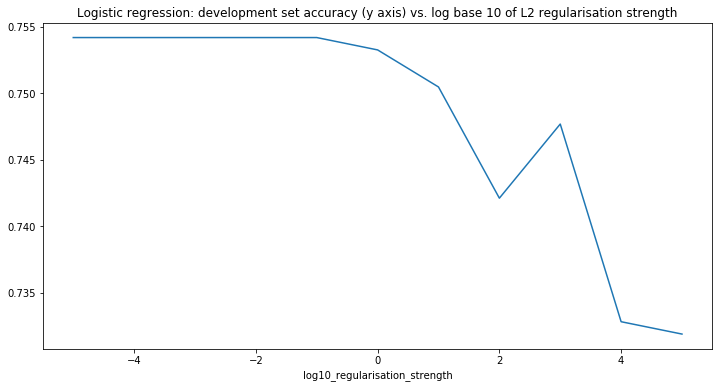

In [38]:
model_LR_with_regularisation_df.set_index('log10_regularisation_strength')['accuracy'].plot(figsize = (12, 6),
                                                                                            title = 'Logistic regression: development set accuracy (y axis) vs. log base 10 of L2 regularisation strength')

We can see that the optimal accuracy occurs at (this can be different every time you run due to the random shuffling and downsampling of data above):

In [39]:
max_accuracy = max(model_LR_with_regularisation_df['accuracy'])

In [40]:
max_inverse_reg_strength = model_LR_with_regularisation_df[model_LR_with_regularisation_df['accuracy'] == max_accuracy].iloc[0]['inverse_regularisation_strength']

In [41]:
max_inverse_reg_strength

10.0

In [42]:
max_accuracy

0.7541743970315399

We omit $L1$ regularisation because the `newton-cg` solver does not support `l1`.

We perform a final evaluation of the model on the test set.

In [43]:
model_LR_final = LogisticRegression(solver = 'newton-cg', C = max_inverse_reg_strength).fit(X_train, Y_train)

In [44]:
model_LR_final_evaluate = evaluate_binary_classifier(model_LR_final, X_test, Y_test)

In [45]:
model_LR_final_evaluate['model'] = 'logistic_regression_newton-cg_C_' + str(max_inverse_reg_strength)

In [46]:
model_LR_final_evaluate

{'TN': 377,
 'FP': 137,
 'FN': 104,
 'TP': 461,
 'total_false': 514,
 'total_true': 565,
 'total': 1079,
 'accuracy': 0.7766450417052827,
 'precision': 0.7709030100334449,
 'recall': 0.815929203539823,
 'F1': 0.7927773000859846,
 'model': 'logistic_regression_newton-cg_C_10.0'}

Our final accuracy for logistic regression, optimised with `newton-cg` with an appropriate inverse $L2$ regularisation strength is:

In [47]:
str(round(100 * model_LR_final_evaluate['accuracy'], 2)) + '%'

'77.66%'

We also display the weights and biases:

In [48]:
bias_and_weights_values = list(model_LR_final.intercept_) + list(model_LR_final.coef_[0])

In [49]:
feature_names = ['bias'] + list(data_balanced)[:-1]

In [50]:
model_LR_final_weights_df = pd.DataFrame(list(zip(feature_names, bias_and_weights_values))).sort_values(by = 1).reset_index(drop = True)

In [51]:
model_LR_final_weights_df.columns = ['feature', 'weights']

In [52]:
model_LR_final_weights_df

,feature,weights
0,PhoneService,-1.091256
1,Contract_is_two_year,-0.815790
2,bias,-0.699986
3,OnlineSecurity,-0.531661
4,TechSupport,-0.474321
5,OnlineBackup,-0.257668
6,DeviceProtection,-0.169834
7,Dependents,-0.154691
8,PaymentMethod_is_bank_transfer,-0.111042
9,PaymentMethod_is_credit_card,-0.107667


We can see that the strongest features whose unit increase increases the log-odds of churn are:

In [53]:
model_LR_final_weights_df.iloc[-3:]

,feature,weights
21,PaymentMethod_is_electronic_check,0.286710
22,PaperlessBilling,0.309947
23,Contract_is_month-to-month,0.763652


The strongest features whose unit increase decreases the log-odds of churn are:

In [54]:
model_LR_final_weights_df[model_LR_final_weights_df['feature'] != 'bias'].iloc[:3]

,feature,weights
0,PhoneService,-1.091256
1,Contract_is_two_year,-0.815790
3,OnlineSecurity,-0.531661


In summary, we have trained a logistic regression model on the test set, adjusted $L2$ regularisation on the development set to obtain the best classification accuracy, did a final evaluation on the test set, and displayed the feature weights to indicate how much does a unit change in the strongest and weakest features affect the log-odds of classification. Note we have dealt with multicollinearity in a previous notebook, so this selection of features is fine for logistic regression.

We gather together the final model performances as follows:

In [55]:
final_results = [model_LR_final_evaluate]

## Decision Trees

We now learn a decision tree on the same data. We will use the dev set to explore different ways to split the tree and regularise. We will also generate explanations. 

How do decision tree classifiers perform given the previous logistic regression model with the following results?

In [56]:
model_LR_final_evaluate

{'TN': 377,
 'FP': 137,
 'FN': 104,
 'TP': 461,
 'total_false': 514,
 'total_true': 565,
 'total': 1079,
 'accuracy': 0.7766450417052827,
 'precision': 0.7709030100334449,
 'recall': 0.815929203539823,
 'F1': 0.7927773000859846,
 'model': 'logistic_regression_newton-cg_C_10.0'}

We follow the syntax from (last accessed 2/4/2022):

  1. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
  
  2. https://scikit-learn.org/stable/modules/tree.html
  
We first train an initial decision tree model and evaluate it (it has a `fit` method). We have ensured the dataset has no missing values.

In [57]:
model_DT0 = DecisionTreeClassifier().fit(X_train, Y_train)

In [58]:
model_DT0_evaluate = evaluate_binary_classifier(model_DT0, X_dev, Y_dev)

In [59]:
model_DT0_evaluate

{'TN': 392,
 'FP': 123,
 'FN': 11,
 'TP': 552,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.87569573283859,
 'precision': 0.8177777777777778,
 'recall': 0.9804618117229129,
 'F1': 0.8917609046849759}

We look at the tree learnt (scroll all the way down):

[Text(127.45,220.933,'X[14] <= 0.5\ngini = 0.499\nsamples = 8624\nvalue = [4145, 4479]'),
 Text(43.88,213.919,'X[22] <= 93.675\ngini = 0.289\nsamples = 2865\nvalue = [2364, 501]'),
 Text(23.3944,206.906,'X[15] <= 0.5\ngini = 0.188\nsamples = 2052\nvalue = [1836, 216]'),
 Text(11.9547,199.892,'X[18] <= 0.5\ngini = 0.066\nsamples = 1089\nvalue = [1052, 37]'),
 Text(9.48443,192.878,'X[1] <= 0.5\ngini = 0.05\nsamples = 1012\nvalue = [986, 26]'),
 Text(7.14037,185.864,'X[4] <= 59.5\ngini = 0.035\nsamples = 943\nvalue = [926, 17]'),
 Text(5.33724,178.851,'X[4] <= 54.5\ngini = 0.054\nsamples = 466\nvalue = [453, 13]'),
 Text(3.02925,171.837,'X[2] <= 0.5\ngini = 0.03\nsamples = 389\nvalue = [383, 6]'),
 Text(1.731,164.823,'X[21] <= 0.5\ngini = 0.061\nsamples = 160\nvalue = [155, 5]'),
 Text(0.576999,157.809,'X[4] <= 52.5\ngini = 0.018\nsamples = 113\nvalue = [112, 1]'),
 Text(0.2885,150.796,'gini = 0.0\nsamples = 102\nvalue = [102, 0]'),
 Text(0.865499,150.796,'X[3] <= 0.5\ngini = 0.165\nsampl

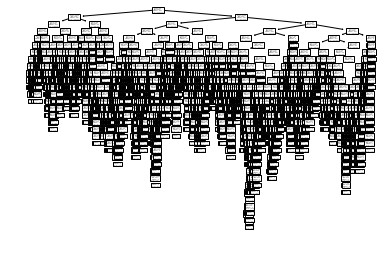

In [60]:
tree.plot_tree(model_DT0)

We can see that initially, the decision tree performs worse than the best logistic regression model and the tree itself is a mess. This is perhaps because we have too many features, forced the decision tree to output until it reaches pure nodes, and the tree has likely overfitted.

We now adjust the decision tree's hyperparameters to see whether we can both boost test accuracy and simplify the tree learnt.

Suppose we change `gini` to `entropy` without changing anything else, do we improve on anything? Recall `gini` is directly calculated with the class probabilities while `entropy` involves the logarithm and can be slower. Further, `gini` ranges from $0$ to $0.5$, while `entropy` ranges from $0$ (no randomness) to $\log(n)$ (uniform distribution), where $n$ is the number of outcomes, given a suitable base for $\log$. The difference is seen as minimal between the two, but we will see what the accuracy of `entropy` gives:

In [61]:
model_DT1 = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, Y_train)

In [62]:
model_DT1_evaluate = evaluate_binary_classifier(model_DT1, X_dev, Y_dev)

In [63]:
model_DT1_evaluate

{'TN': 398,
 'FP': 117,
 'FN': 16,
 'TP': 547,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.8766233766233766,
 'precision': 0.8237951807228916,
 'recall': 0.9715808170515098,
 'F1': 0.8916055419722902}

Compare the accuracies:

In [64]:
model_DT0_evaluate['accuracy'], model_DT1_evaluate['accuracy']

(0.87569573283859, 0.8766233766233766)

It is possible for entropy to do better depending on how we have downsampled or upsampled (see above). In the case of upsampling, `entropy` does slightly better. We keep `gini` to measure the quality of the split as it is the default setting and should be faster.

**N.B.** Given more time we can repeat the below evaluations with both `gini` and `entropy` and select the models out of that.

We now consider adjusting the depth of the tree, from 1 to 20, and measure the test accuracy.

In [65]:
DT_evaluate_by_depth = []
for height in range(1, 21):
    mymodel = DecisionTreeClassifier(max_depth = height).fit(X_train, Y_train)
    evaluation = evaluate_binary_classifier(mymodel, X_dev, Y_dev)
    evaluation['max_depth'] = height
    DT_evaluate_by_depth.append(evaluation)

In [66]:
DT_evaluation_df = pd.DataFrame(DT_evaluate_by_depth)

In [67]:
DT_evaluation_df

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,max_depth
0,286,229,70,493,515,563,1078,0.722635,0.682825,0.875666,0.767315,1
1,286,229,70,493,515,563,1078,0.722635,0.682825,0.875666,0.767315,2
2,360,155,113,450,515,563,1078,0.751391,0.743802,0.799290,0.770548,3
3,348,167,96,467,515,563,1078,0.756030,0.736593,0.829485,0.780284,4
4,352,163,82,481,515,563,1078,0.772727,0.746894,0.854352,0.797017,5
5,368,147,106,457,515,563,1078,0.765306,0.756623,0.811723,0.783205,6
6,343,172,69,494,515,563,1078,0.776438,0.741742,0.877442,0.803906,7
7,346,169,66,497,515,563,1078,0.782004,0.746246,0.882771,0.808788,8
8,355,160,68,495,515,563,1078,0.788497,0.755725,0.879218,0.812808,9
9,347,168,59,504,515,563,1078,0.789425,0.750000,0.895204,0.816194,10


We plot how the accuracy changes by depth:

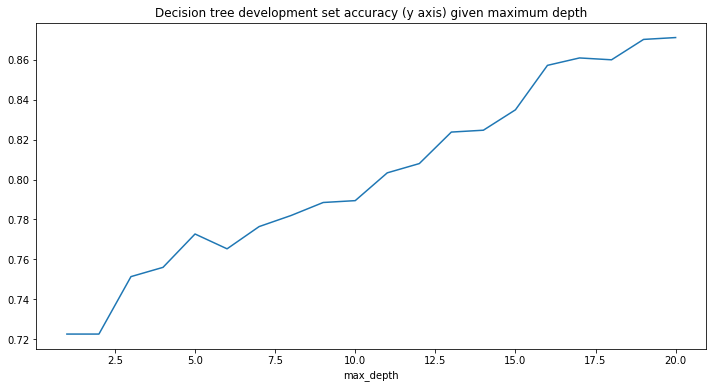

In [68]:
DT_evaluation_df.set_index('max_depth')['accuracy'].plot(figsize = (12, 6),
                                                         title = 'Decision tree development set accuracy (y axis) given maximum depth')

The accuracy on the development set is maximised at:

In [69]:
max_DT_accuracy = max(DT_evaluation_df['accuracy'])

In [70]:
most_accurate_row = DT_evaluation_df[DT_evaluation_df['accuracy'] == max_DT_accuracy]

In [71]:
most_accurate_depth = most_accurate_row.iloc[0]['max_depth']

We have, the most accurate depth and its accuracy:

In [72]:
most_accurate_depth, max_DT_accuracy

(20.0, 0.8710575139146568)

We therefore finalise the decision tree model:

In [73]:
model_DT_final = DecisionTreeClassifier(max_depth = most_accurate_depth).fit(X_train, Y_train)

In [74]:
model_DT_final_evaluate = evaluate_binary_classifier(model_DT_final, X_test, Y_test)

In [75]:
model_DT_final_evaluate['model'] = 'decision_tree_max_depth_' + str(int(most_accurate_depth))

The final results are:

In [76]:
model_DT_final_evaluate

{'TN': 404,
 'FP': 110,
 'FN': 14,
 'TP': 551,
 'total_false': 514,
 'total_true': 565,
 'total': 1079,
 'accuracy': 0.8850787766450418,
 'precision': 0.8335854765506808,
 'recall': 0.9752212389380531,
 'F1': 0.8988580750407831,
 'model': 'decision_tree_max_depth_20'}

Compare this to logistic regression:

In [77]:
model_LR_final_evaluate

{'TN': 377,
 'FP': 137,
 'FN': 104,
 'TP': 461,
 'total_false': 514,
 'total_true': 565,
 'total': 1079,
 'accuracy': 0.7766450417052827,
 'precision': 0.7709030100334449,
 'recall': 0.815929203539823,
 'F1': 0.7927773000859846,
 'model': 'logistic_regression_newton-cg_C_10.0'}

Using Gini split and pruning the tree up to a given max depth has improved initial accuracy of

In [78]:
str(round(100 * model_DT0_evaluate['accuracy'], 2)) + '%'

'87.57%'

to

In [79]:
str(round(100 * model_DT_final_evaluate['accuracy'], 2)) + '%'

'88.51%'

We consider how the tree can be visualised.

[Text(131.489,219.096,'X[14] <= 0.5\ngini = 0.499\nsamples = 8624\nvalue = [4145, 4479]'),
 Text(51.489,208.409,'X[22] <= 93.675\ngini = 0.289\nsamples = 2865\nvalue = [2364, 501]'),
 Text(36.0358,197.721,'X[16] <= 0.5\ngini = 0.188\nsamples = 2052\nvalue = [1836, 216]'),
 Text(21.6466,187.033,'X[13] <= 0.5\ngini = 0.303\nsamples = 963\nvalue = [784, 179]'),
 Text(14.0688,176.346,'X[18] <= 0.5\ngini = 0.216\nsamples = 658\nvalue = [577, 81]'),
 Text(10.315,165.658,'X[4] <= 48.5\ngini = 0.174\nsamples = 540\nvalue = [488, 52]'),
 Text(6.71972,154.97,'X[7] <= 0.5\ngini = 0.218\nsamples = 385\nvalue = [337, 48]'),
 Text(2.20972,144.283,'X[4] <= 2.5\ngini = 0.134\nsamples = 236\nvalue = [219, 17]'),
 Text(0.579598,133.595,'X[19] <= 0.5\ngini = 0.48\nsamples = 10\nvalue = [6, 4]'),
 Text(0.289799,122.908,'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.869397,122.908,'X[4] <= 1.5\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(0.579598,112.22,'gini = 0.0\nsamples = 3\nvalue = [3, 0]'

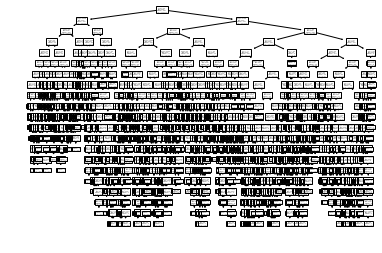

In [80]:
tree.plot_tree(model_DT_final)

We follow https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc (last accessed 3/4/2022) to try to improve the plot somewhat:

In [81]:
fn = list(data_balanced)[:-1]
cn = ['0', '1']

[Text(131.489,219.096,'Contract_is_month-to-month <= 0.5\ngini = 0.499\nsamples = 8624\nvalue = [4145, 4479]\nclass = 1'),
 Text(51.489,208.409,'MonthlyCharges <= 93.675\ngini = 0.289\nsamples = 2865\nvalue = [2364, 501]\nclass = 0'),
 Text(36.0358,197.721,'Contract_is_two_year <= 0.5\ngini = 0.188\nsamples = 2052\nvalue = [1836, 216]\nclass = 0'),
 Text(21.6466,187.033,'StreamingMovies <= 0.5\ngini = 0.303\nsamples = 963\nvalue = [784, 179]\nclass = 0'),
 Text(14.0688,176.346,'PaymentMethod_is_electronic_check <= 0.5\ngini = 0.216\nsamples = 658\nvalue = [577, 81]\nclass = 0'),
 Text(10.315,165.658,'tenure/month <= 48.5\ngini = 0.174\nsamples = 540\nvalue = [488, 52]\nclass = 0'),
 Text(6.71972,154.97,'internet_service_is_dsl <= 0.5\ngini = 0.218\nsamples = 385\nvalue = [337, 48]\nclass = 0'),
 Text(2.20972,144.283,'tenure/month <= 2.5\ngini = 0.134\nsamples = 236\nvalue = [219, 17]\nclass = 0'),
 Text(0.579598,133.595,'PaymentMethod_is_mailed_check <= 0.5\ngini = 0.48\nsamples = 10\n

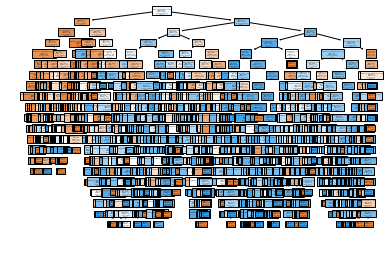

In [82]:
tree.plot_tree(model_DT_final,
               feature_names = fn,
               class_names = cn,
               filled = True)

We still cannot see the text in each box...

**N.B.** This can be adjusted in future such that we can get its explanations!

We gather together the final results:

In [83]:
final_results.append(model_DT_final_evaluate)

## Random Forest

We now bag many decision trees, each possibly learning from different subsets of features, into a random forest classifier and adjust its hyperparameters to see what accuracies we can achieve. Note that as stated before the dataset has been adjusted for multicollinearity to avoid problems with logistic regression. Random forest is not affected by multicollinearity due to the variable features each tree takes. However, for a fair comparison of models we will train and evaluate all of them on the same dataset that is absent of multicollinearity.

See https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html for syntax.

We set `random_state` equal to $1$ for reproducibility.

In [84]:
model_RF0 = RandomForestClassifier(random_state = 1).fit(X_train, Y_train)

In [85]:
model_RF0_evaluate = evaluate_binary_classifier(model_RF0, X_dev, Y_dev)

In [86]:
model_RF0_evaluate

{'TN': 425,
 'FP': 90,
 'FN': 11,
 'TP': 552,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.9063079777365491,
 'precision': 0.8598130841121495,
 'recall': 0.9804618117229129,
 'F1': 0.9161825726141077}

We now adjust the hyperparameters to find the best model:

  1. The number of trees in the forest (more trees means better performance but diminishing returns and also longer training time)
  
  2. The maximum depth of each tree (up to 15 as we saw from a single decision tree above having a max depth of 10 or above does not really improve accuracy)
  
We keep `gini` as the means of measuring the splitting quality.

In [87]:
num_trees_range = [10, 100, 10**3, 10**4]
tree_depth_max = range(1, 16)

In [88]:
RF_hyperparameters = list(product(num_trees_range, tree_depth_max))

How many hyperparameter combinations do we have?

In [89]:
len(RF_hyperparameters)

60

We now search these combinations of hyperparameters, learn the corresponding model on the training set, and evaluate it on the dev set. This takes approximately **5 - 20 minutes** (depending on whether you have upsampled or downsampled above).

In [90]:
random_forest_results = []
for num_trees, depth_max in tqdm(RF_hyperparameters):
    model_RF = RandomForestClassifier(n_estimators = num_trees,
                                      max_depth = depth_max,
                                      random_state = 1).fit(X_train, Y_train)
    myrow = evaluate_binary_classifier(model_RF, X_dev, Y_dev)
    myrow['num_trees'] = num_trees
    myrow['max_depth'] = depth_max
    random_forest_results.append(myrow)

100%|██████████| 60/60 [16:12<00:00, 16.20s/it]


We gather together and visualise the results.

In [91]:
random_forest_results_df = pd.DataFrame(random_forest_results)

In [92]:
random_forest_results_df

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,num_trees,max_depth
0,315,200,103,460,515,563,1078,0.718924,0.696970,0.817052,0.752249,10,1
1,296,219,75,488,515,563,1078,0.727273,0.690240,0.866785,0.768504,10,2
2,310,205,76,487,515,563,1078,0.739332,0.703757,0.865009,0.776096,10,3
3,319,196,78,485,515,563,1078,0.745826,0.712188,0.861456,0.779743,10,4
4,350,165,105,458,515,563,1078,0.749536,0.735152,0.813499,0.772344,10,5
5,348,167,90,473,515,563,1078,0.761596,0.739062,0.840142,0.786367,10,6
6,346,169,78,485,515,563,1078,0.770872,0.741590,0.861456,0.797042,10,7
7,359,156,82,481,515,563,1078,0.779221,0.755102,0.854352,0.801667,10,8
8,356,159,58,505,515,563,1078,0.798701,0.760542,0.896980,0.823146,10,9
9,380,135,45,518,515,563,1078,0.833024,0.793262,0.920071,0.851974,10,10


We visualise these results by number of trees:

In [93]:
random_forest_results_pivot_df = random_forest_results_df.pivot(index = 'max_depth', columns = 'num_trees', values = 'accuracy')

In [94]:
random_forest_results_pivot_df

num_trees,10,100,1000,10000
max_depth,,,,
1,0.718924,0.722635,0.720779,0.723562
2,0.727273,0.724490,0.726345,0.727273
3,0.739332,0.733766,0.727273,0.730056
4,0.745826,0.736549,0.737477,0.737477
5,0.749536,0.745826,0.748609,0.743970
6,0.761596,0.761596,0.763451,0.765306
7,0.770872,0.774583,0.772727,0.778293
8,0.779221,0.788497,0.793135,0.788497
9,0.798701,0.812616,0.809833,0.810761


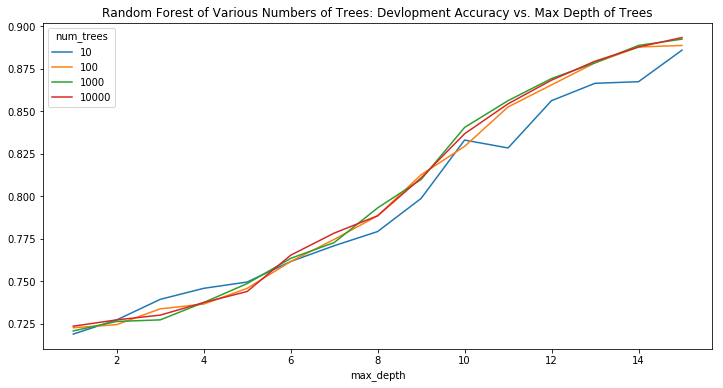

In [95]:
random_forest_results_pivot_df.plot(figsize = (12, 6),
                                    title = 'Random Forest of Various Numbers of Trees: Devlopment Accuracy vs. Max Depth of Trees')

The most accurate set of hyperparameters with the least number of trees and the smallest depth according to the dev set is as follows:

In [96]:
max_RF_accuracy = max(random_forest_results_df['accuracy'])

In [97]:
best_RF_hyperparameters_df = random_forest_results_df[random_forest_results_df['accuracy'] == max_RF_accuracy].sort_values(by = ['num_trees', 'max_depth'])

In [98]:
best_RF_hyperparameters_df

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,num_trees,max_depth
59,408,107,8,555,515,563,1078,0.893321,0.838369,0.98579,0.906122,10000,15


We select the hyperparameters with the smallest number of trees.

In [99]:
best_RF_hyperparameters_smallest_num_trees = dict(best_RF_hyperparameters_df.sort_values(by = 'num_trees').iloc[0])

In [100]:
best_num_trees = int(best_RF_hyperparameters_smallest_num_trees['num_trees'])
best_depth = int(best_RF_hyperparameters_smallest_num_trees['max_depth'])

We then retrain with these hyperparameters on the training set:

In [101]:
model_RF_final = RandomForestClassifier(n_estimators = int(best_num_trees),
                                        max_depth = int(best_depth),
                                        random_state = 1).fit(X_train, Y_train)

We evaluate the model on the test set to give the final results.

In [102]:
model_RF_final_evaluate = evaluate_binary_classifier(model_RF_final, X_test, Y_test)

In [103]:
model_RF_final_evaluate['model'] = 'random_forest_' + str(int(best_num_trees)) + '_trees_depth_' + str(int(best_depth))

In [104]:
model_RF_final_evaluate

{'TN': 409,
 'FP': 105,
 'FN': 10,
 'TP': 555,
 'total_false': 514,
 'total_true': 565,
 'total': 1079,
 'accuracy': 0.8934198331788693,
 'precision': 0.8409090909090909,
 'recall': 0.9823008849557522,
 'F1': 0.9061224489795919,
 'model': 'random_forest_10000_trees_depth_15'}

We add this to the results:

In [105]:
final_results.append(model_RF_final_evaluate)

We can inspect the three models so far:

In [106]:
pd.DataFrame(final_results)

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,model
0,377,137,104,461,514,565,1079,0.776645,0.770903,0.815929,0.792777,logistic_regression_newton-cg_C_10.0
1,404,110,14,551,514,565,1079,0.885079,0.833585,0.975221,0.898858,decision_tree_max_depth_20
2,409,105,10,555,514,565,1079,0.893420,0.840909,0.982301,0.906122,random_forest_10000_trees_depth_15


Depending on whether we have upsampled or downsampled above, and the randomness of the shuffling and sampling, the models can have similar performances or different performances.

## Gradient Boosting

Can we outperform random forest with a gradient boosted classifier?

We train an initial model with default settings, see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html.

In [107]:
model_GB0 = GradientBoostingClassifier().fit(X_train, Y_train)

In [108]:
model_GB0_evaluate = evaluate_binary_classifier(model_GB0, X_dev, Y_dev)

In [109]:
model_GB0_evaluate

{'TN': 360,
 'FP': 155,
 'FN': 84,
 'TP': 479,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.7782931354359925,
 'precision': 0.7555205047318612,
 'recall': 0.8507992895204263,
 'F1': 0.8003341687552212}

The initial accuracy is fair, we now perform the usual hyperparameter searches on the development set. For gradient boosting classifiers, the hyperparameters are:

  1. Number of trees (default $100$)
  
  2. Learning rate (default $0.1$)
  
  3. Depth of trees (default $3$)
  
We take the same ranges as for the random forest, and the learning rate we will vary across three orders of magnitude: $0.01, 0.1, 1$. We keep the rest of the settings the same.

In [110]:
GB_hyperparameters = [(pair[0][0], pair[0][1], pair[1]) for pair in tqdm(list(product(RF_hyperparameters, [0.01, 0.1, 1])))]

100%|██████████| 180/180 [00:00<00:00, 236595.02it/s]


In [111]:
GB_hyperparameters = [item for item in GB_hyperparameters if item[0] < 10**4]

In [112]:
len(GB_hyperparameters)

135

We evaluate each setting on the dev set. This takes around **15 - 30 minutes**.

In [113]:
gradient_boosting_results = []
for num_trees, depth_max, rate in tqdm(GB_hyperparameters):
    model_GB = GradientBoostingClassifier(n_estimators = num_trees,
                                          max_depth = depth_max,
                                          learning_rate = rate).fit(X_train, Y_train)
    myrow = evaluate_binary_classifier(model_GB, X_dev, Y_dev)
    myrow['num_trees'] = num_trees
    myrow['max_depth'] = depth_max
    myrow['learning_rate'] = rate
    gradient_boosting_results.append(myrow)

100%|██████████| 135/135 [32:14<00:00, 14.33s/it]


In [114]:
gradient_boosting_results_df = pd.DataFrame(gradient_boosting_results)

In [115]:
gradient_boosting_results_df

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,num_trees,max_depth,learning_rate
0,286,229,70,493,515,563,1078,0.722635,0.682825,0.875666,0.767315,10,1,0.01
1,286,229,70,493,515,563,1078,0.722635,0.682825,0.875666,0.767315,10,1,0.10
2,359,156,110,453,515,563,1078,0.753247,0.743842,0.804618,0.773038,10,1,1.00
3,224,291,27,536,515,563,1078,0.705009,0.648126,0.952043,0.771223,10,2,0.01
4,286,229,70,493,515,563,1078,0.722635,0.682825,0.875666,0.767315,10,2,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,447,68,11,552,515,563,1078,0.926716,0.890323,0.980462,0.933221,1000,14,0.10
131,472,43,12,551,515,563,1078,0.948980,0.927609,0.978686,0.952463,1000,14,1.00
132,406,109,10,553,515,563,1078,0.889610,0.835347,0.982238,0.902857,1000,15,0.01
133,441,74,12,551,515,563,1078,0.920223,0.881600,0.978686,0.927609,1000,15,0.10


For each learning rate, we plot how `accuracy` depends on `max_depth`:

In [116]:
gradient_boosting_results_df_LR1 = gradient_boosting_results_df[gradient_boosting_results_df['learning_rate'] == 0.01]
gradient_boosting_results_df_LR2 = gradient_boosting_results_df[gradient_boosting_results_df['learning_rate'] == 0.1]
gradient_boosting_results_df_LR3 = gradient_boosting_results_df[gradient_boosting_results_df['learning_rate'] == 1]

We form the pivot tables:

In [117]:
gradient_boosting_results_df_LR1_pivot = gradient_boosting_results_df_LR1.pivot(index = 'max_depth', columns = 'num_trees', values = 'accuracy')
gradient_boosting_results_df_LR2_pivot = gradient_boosting_results_df_LR2.pivot(index = 'max_depth', columns = 'num_trees', values = 'accuracy')
gradient_boosting_results_df_LR3_pivot = gradient_boosting_results_df_LR3.pivot(index = 'max_depth', columns = 'num_trees', values = 'accuracy')

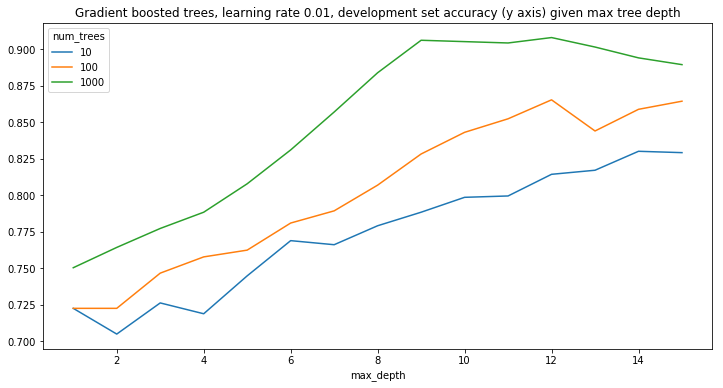

In [118]:
gradient_boosting_results_df_LR1_pivot.plot(figsize = (12, 6),
                                            title = 'Gradient boosted trees, learning rate 0.01, development set accuracy (y axis) given max tree depth')

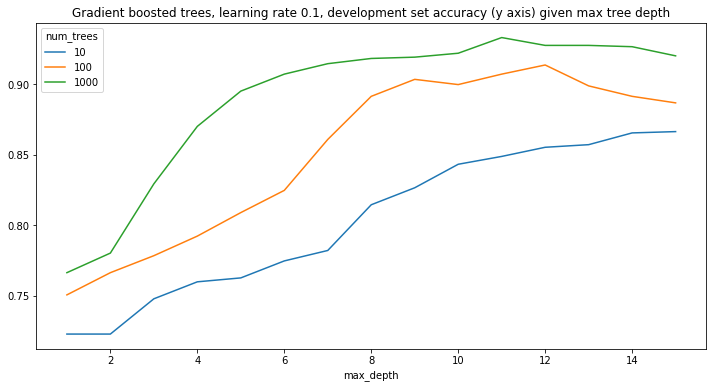

In [119]:
gradient_boosting_results_df_LR2_pivot.plot(figsize = (12, 6),
                                            title = 'Gradient boosted trees, learning rate 0.1, development set accuracy (y axis) given max tree depth')

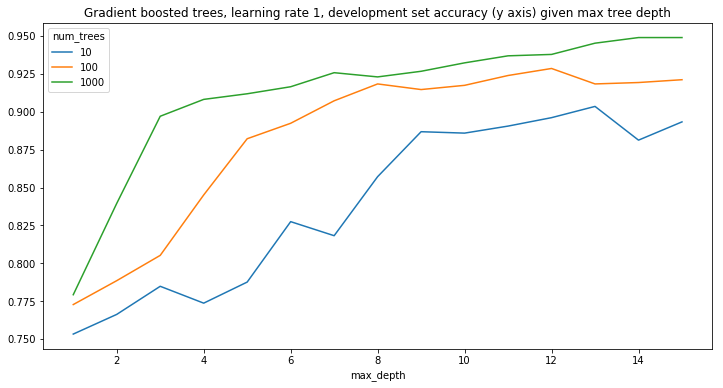

In [120]:
gradient_boosting_results_df_LR3_pivot.plot(figsize = (12, 6),
                                            title = 'Gradient boosted trees, learning rate 1, development set accuracy (y axis) given max tree depth')

We find the most accurate models. From these models, we choose the one with the smallest learning rate and smallest number of trees and the smallest depth.

In [121]:
max_accuracy = max(gradient_boosting_results_df['accuracy'])

In [122]:
gradient_boosting_results_df_max_acc = gradient_boosting_results_df[gradient_boosting_results_df['accuracy'] == max_accuracy].sort_values(by = ['learning_rate', 'num_trees', 'max_depth'])

In [123]:
gradient_boosting_results_df_max_acc

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,num_trees,max_depth,learning_rate
131,472,43,12,551,515,563,1078,0.94898,0.927609,0.978686,0.952463,1000,14,1.0
134,472,43,12,551,515,563,1078,0.94898,0.927609,0.978686,0.952463,1000,15,1.0


In [124]:
best_gradient_boosting_model = dict(gradient_boosting_results_df_max_acc.iloc[0])

In [125]:
best_gradient_boosting_model

{'TN': 472.0,
 'FP': 43.0,
 'FN': 12.0,
 'TP': 551.0,
 'total_false': 515.0,
 'total_true': 563.0,
 'total': 1078.0,
 'accuracy': 0.9489795918367347,
 'precision': 0.9276094276094277,
 'recall': 0.9786856127886323,
 'F1': 0.9524632670700086,
 'num_trees': 1000.0,
 'max_depth': 14.0,
 'learning_rate': 1.0}

We get the best hyperparameters.

In [126]:
best_num_trees = int(best_gradient_boosting_model['num_trees'])
best_max_depth = int(best_gradient_boosting_model['max_depth'])
best_learning_rate = best_gradient_boosting_model['learning_rate']

We train the best model given these hyperparameters. This can take **1 minute**.

In [127]:
start = time.time()
model_GB_final = GradientBoostingClassifier(n_estimators = int(best_num_trees),
                                            max_depth = int(best_max_depth),
                                            learning_rate = best_learning_rate).fit(X_train, Y_train)
"Done in " + str(datetime.timedelta(seconds=time.time() - start)) + "."

'Done in 0:00:57.940096.'

We evaluate this model:

In [128]:
model_GB_final_evaluate = evaluate_binary_classifier(model_GB_final, X_test, Y_test)

In [129]:
model_GB_final_evaluate['model'] = 'gradient_boosting_' + str(best_num_trees) + "_trees_depth_" + str(best_max_depth) + "_learning_rate_" + str(best_learning_rate)

We add this model to the final results.

In [130]:
final_results.append(model_GB_final_evaluate)

We check this with the previous models.

In [131]:
pd.DataFrame(final_results)

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,model
0,377,137,104,461,514,565,1079,0.776645,0.770903,0.815929,0.792777,logistic_regression_newton-cg_C_10.0
1,404,110,14,551,514,565,1079,0.885079,0.833585,0.975221,0.898858,decision_tree_max_depth_20
2,409,105,10,555,514,565,1079,0.893420,0.840909,0.982301,0.906122,random_forest_10000_trees_depth_15
3,475,39,11,554,514,565,1079,0.953661,0.934233,0.980531,0.956822,gradient_boosting_1000_trees_depth_14_learning...


## Support Vector Machines

Finally, we train and evaluate a support vector machine (SVM) on the data. See https://scikit-learn.org/stable/modules/svm.html and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC for syntax.

We do an initial evaluation:

In [132]:
model_SVM0 = SVC().fit(X_train, Y_train)

In [133]:
model_SVM0_evaluate = evaluate_binary_classifier(model_SVM0, X_dev, Y_dev)

In [134]:
model_SVM0_evaluate

{'TN': 336,
 'FP': 179,
 'FN': 98,
 'TP': 465,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.7430426716141002,
 'precision': 0.7220496894409938,
 'recall': 0.8259325044404974,
 'F1': 0.7705053852526927}

We search the hyperparameters:

  1. `C` for $L2$ penalty that is strictly positive.
  
  2. The various kernels for the SVM: `linear`, `poly`, `rbf` (default), `sigmoid`, `precomputed`. We ignore `precomputed` as our input is not a square matrix.
  
  3. `degree` for `poly` kernel: $2$, $3$ (default), $4$

In [135]:
SVM_regularisation = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [136]:
SVM_kernel = ['linear', 'rbf', 'sigmoid']

In [137]:
SVM_degree = [2,3,4]

In [138]:
SVM_hyperparameters1 = list(product(SVM_regularisation, SVM_kernel, [3]))

In [139]:
SVM_hyperparameters2 = list(product(SVM_regularisation, ['poly'], SVM_degree))

In [140]:
SVM_hyperparameters = SVM_hyperparameters1 + SVM_hyperparameters2

In [141]:
len(SVM_hyperparameters)

42

The evaluation of the SVMs given different hyperparameters take **5 to 20 minutes** to generate.

In [142]:
SVM_results = []
for regularisation_parameter, kernel_type, poly_degree in tqdm(SVM_hyperparameters):
    model_SVM = SVC(C = regularisation_parameter,
                    kernel = kernel_type,
                    degree = poly_degree).fit(X_train, Y_train)
    myrow = evaluate_binary_classifier(model_SVM, X_dev, Y_dev)
    myrow['regularisation'] = regularisation_parameter
    myrow['kernel'] = kernel_type
    myrow['degree'] = poly_degree
    SVM_results.append(myrow)

100%|██████████| 42/42 [19:28<00:00, 27.82s/it]   


In [143]:
SVM_results_df = pd.DataFrame(SVM_results)

In [144]:
SVM_results_df

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,regularisation,kernel,degree
0,356,159,101,462,515,563,1078,0.758813,0.743961,0.820604,0.780405,0.001,linear,3
1,155,360,13,550,515,563,1078,0.653989,0.604396,0.976909,0.746775,0.001,rbf,3
2,0,515,0,563,515,563,1078,0.522263,0.522263,1.000000,0.686167,0.001,sigmoid,3
3,335,180,102,461,515,563,1078,0.738404,0.719189,0.818828,0.765781,0.010,linear,3
4,366,149,141,422,515,563,1078,0.730983,0.739054,0.749556,0.744268,0.010,rbf,3
5,230,285,31,532,515,563,1078,0.706865,0.651163,0.944938,0.771014,0.010,sigmoid,3
6,333,182,101,462,515,563,1078,0.737477,0.717391,0.820604,0.765534,0.100,linear,3
7,334,181,99,464,515,563,1078,0.740260,0.719380,0.824156,0.768212,0.100,rbf,3
8,344,171,218,345,515,563,1078,0.639147,0.668605,0.612789,0.639481,0.100,sigmoid,3
9,333,182,101,462,515,563,1078,0.737477,0.717391,0.820604,0.765534,1.000,linear,3


For visualisation purposes, we merge the `degree` and `kernel` columns:

In [145]:
SVM_results_df2 = SVM_results_df.copy()

In [146]:
SVM_results_df2['kernel_and_degree'] = SVM_results_df2['kernel'] + SVM_results_df2['degree'].astype(str)

In [147]:
SVM_results_df2 = SVM_results_df2.drop(columns = ['kernel', 'degree'])

In [148]:
SVM_results_df2 = SVM_results_df2.replace('linear3', 'linear')
SVM_results_df2 = SVM_results_df2.replace('rbf3', 'rbf')
SVM_results_df2 = SVM_results_df2.replace('sigmoid3', 'sigmoid')

We plot this against the logarithm of the regularisation parameter:

In [149]:
SVM_results_df2['log_10_regularisation'] = np.log10(SVM_results_df2['regularisation'])

In [150]:
SVM_results_df2_pivot = SVM_results_df2.pivot(index = 'log_10_regularisation',
                      columns = 'kernel_and_degree',
                      values = 'accuracy')

In [151]:
SVM_results_df2_pivot

kernel_and_degree,linear,poly2,poly3,poly4,rbf,sigmoid
log_10_regularisation,,,,,,
-3.0,0.758813,0.699443,0.675325,0.687384,0.653989,0.522263
-2.0,0.738404,0.730983,0.717069,0.706865,0.730983,0.706865
-1.0,0.737477,0.729128,0.702226,0.698516,0.740260,0.639147
0.0,0.737477,0.724490,0.713358,0.719852,0.743043,0.615955
1.0,0.747681,0.740260,0.725417,0.718924,0.753247,0.613173
2.0,0.759740,0.750464,0.737477,0.723562,0.750464,0.613173
3.0,0.756957,0.756030,0.746753,0.749536,0.766234,0.613173


We visualise how dev-set accuracy varies given the log base 10 of the regularisation parameter.

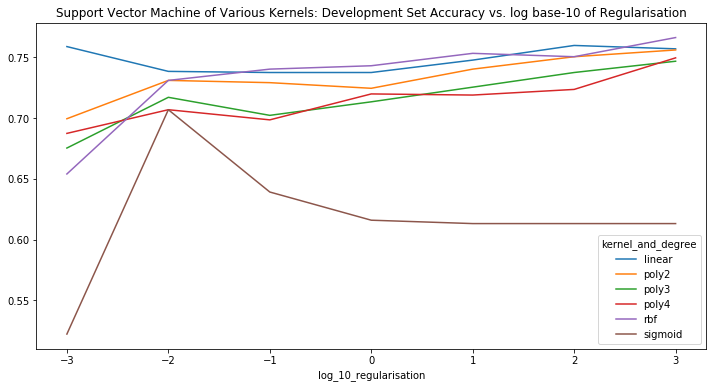

In [152]:
SVM_results_df2_pivot.plot(legend = 'bottom right',
                           figsize = (12, 6),
                           title = 'Support Vector Machine of Various Kernels: Development Set Accuracy vs. log base-10 of Regularisation')

We locate the most accurate model (sort by accuracy and then by $F_1$) and its hyperparameters:

In [153]:
best_SVM_accuracy = max(SVM_results_df['accuracy'])

In [154]:
most_accurate_SVMs = SVM_results_df[SVM_results_df['accuracy'] == best_SVM_accuracy].sort_values(by = 'F1', ascending = False).reset_index(drop = True)

In [155]:
most_accurate_SVMs

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,regularisation,kernel,degree
0,363,152,100,463,515,563,1078,0.766234,0.752846,0.82238,0.786078,1000.0,rbf,3


We choose the most accurate model with the highest $F_1$:

In [156]:
best_SVM = dict(most_accurate_SVMs.iloc[0])

In [157]:
best_SVM

{'TN': 363,
 'FP': 152,
 'FN': 100,
 'TP': 463,
 'total_false': 515,
 'total_true': 563,
 'total': 1078,
 'accuracy': 0.7662337662337663,
 'precision': 0.7528455284552845,
 'recall': 0.822380106571936,
 'F1': 0.7860780984719863,
 'regularisation': 1000.0,
 'kernel': 'rbf',
 'degree': 3}

We get its hyperparameters:

In [158]:
best_reg_param = best_SVM['regularisation']
best_kernel = best_SVM['kernel']
best_degree = best_SVM['degree']

We train the final model with these parameters and evaluate it on the test set.

In [159]:
start = time.time()
model_SVM_final = SVC(C = best_reg_param,
                      kernel = best_kernel,
                      degree = best_degree).fit(X_train, Y_train)
"Done in " + str(datetime.timedelta(seconds=time.time() - start)) + "."

'Done in 0:00:08.993821.'

In [160]:
model_SVM_final_evaluate = evaluate_binary_classifier(model_SVM_final, X_test, Y_test)

In [161]:
model_SVM_final_evaluate['model'] = 'SVM_regularisation_' + str(best_reg_param) + "_kernel_" + str(best_kernel) + "_degree_" + str(best_degree)

In [162]:
model_SVM_final_evaluate

{'TN': 370,
 'FP': 144,
 'FN': 98,
 'TP': 467,
 'total_false': 514,
 'total_true': 565,
 'total': 1079,
 'accuracy': 0.7757182576459685,
 'precision': 0.7643207855973814,
 'recall': 0.8265486725663717,
 'F1': 0.79421768707483,
 'model': 'SVM_regularisation_1000.0_kernel_rbf_degree_3'}

We include this in our results:

In [163]:
final_results.append(model_SVM_final_evaluate)

# Choosing the Best Model

We sort the final results from most to least accurate, then from highest to lowest $F_1$ to get:

In [164]:
final_results = pd.DataFrame(final_results).sort_values(by = ['accuracy', 'F1'], ascending = [False, False])

In [165]:
final_results

,TN,FP,FN,TP,total_false,total_true,total,accuracy,precision,recall,F1,model
3,475,39,11,554,514,565,1079,0.953661,0.934233,0.980531,0.956822,gradient_boosting_1000_trees_depth_14_learning...
2,409,105,10,555,514,565,1079,0.893420,0.840909,0.982301,0.906122,random_forest_10000_trees_depth_15
1,404,110,14,551,514,565,1079,0.885079,0.833585,0.975221,0.898858,decision_tree_max_depth_20
0,377,137,104,461,514,565,1079,0.776645,0.770903,0.815929,0.792777,logistic_regression_newton-cg_C_10.0
4,370,144,98,467,514,565,1079,0.775718,0.764321,0.826549,0.794218,SVM_regularisation_1000.0_kernel_rbf_degree_3


These results may be different if you change the downsampling random state or if you do upsampling.

**N.B.** Downsampling with the above default random seed settings will give models that perform with accuracy around $73.5\%$. The best model is still the gradient boosted tree, but with different hyperparameters.

The best model is:

In [166]:
final_results.iloc[0]['model']

'gradient_boosting_1000_trees_depth_14_learning_rate_1.0'

If we upsampled the data and train on that, the best model is a gradient boosted tree with $1000$ trees, maximum depth $14$, and learning rate $1.0$. **This may be different if you downsample instead, shuffle the dataset differently... etc.** We train this model on *all* the data with these hyperparameters:

In [167]:
best_num_trees, best_max_depth, best_learning_rate

(1000, 14, 1.0)

This takes **1 minute**.

In [168]:
start = time.time()
best_model = GradientBoostingClassifier(n_estimators = int(best_num_trees),
                                        max_depth = int(best_max_depth),
                                        learning_rate = best_learning_rate).fit(X_all, Y_all)
"Done in " + str(datetime.timedelta(seconds=time.time() - start)) + "."

'Done in 0:00:52.761103.'

We will carry this model over to the next section.

**N.B.** This result may change if the `random_state` changes in the above, i.e. in the random forest model and the downsampling of the dataframe. But given the above `random_state` settings we will take this result as given.

# Explaining the Features

Given that we have experimented with a range of models above, and we have found the most accurate one (by accuracy and then $F_1$), we will use SHAP to explain in terms of the most accurate model which features (without multicollinearity) are important in explaining customer churn. Intuitively, the Shapley value is a measure of the contribution of each feature towards the model predictions; this gives us a way of determining which features are important in the prediction of each set of inputs, as well as overall for the entire dataset.

We use code snippets from https://www.datatrigger.org/post/interpretable_machine_learning_shap/ (last accessed 3/4/2022).

First we create an explainer object for the above `best_model`.

In [169]:
explainer = shap.TreeExplainer(best_model)

Then we calculate the Shapley values of the whole dataset (inputs only). This takes **5 - 35 minutes**.

In [170]:
data_balanced_inputs = data_balanced.drop(['Churn'], axis = 1)

In [171]:
start = time.time()
shap_values = explainer.shap_values(data_balanced_inputs)
"Done in " + str(datetime.timedelta(seconds=time.time() - start)) + "."

'Done in 0:30:12.447860.'

We can visualise the Shapley values given the features used in the best model. The following is a beeswarm plot:

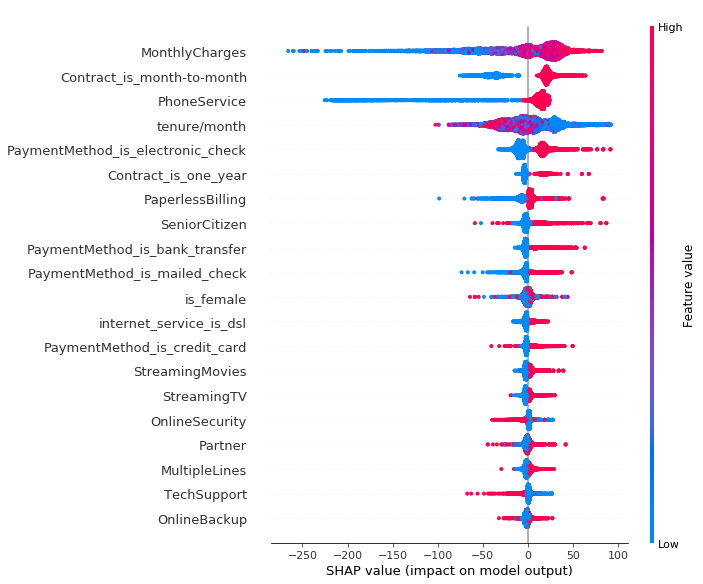

In [172]:
shap.summary_plot(shap_values, data_balanced_inputs)

How should we interpret this?

  1. The $y$ axis contains each feature used in the best model, ordered from the most important (top) to the least. Notice that this does not have to be all of the features present given the nature of the model (e.g. in a random forest each tree uses a subset of features).
  
  2. The $x$ axis is the Shapley value calculated per observation in `shap`; this $1D$ scatterplot is "viewed from above".
  
  3. Red means churn is pushed up, blue means churn is pushed down. For some features, a higher scatter of Shapley values (i.e. more to the right) that are red means this feature drives churn up. Conversely, if there are more blue points to the right means this feature drives churn down.
  
We can simplify the beeswarm plot slightly by calculating the average of the absolute values of the Shapley values per observation.

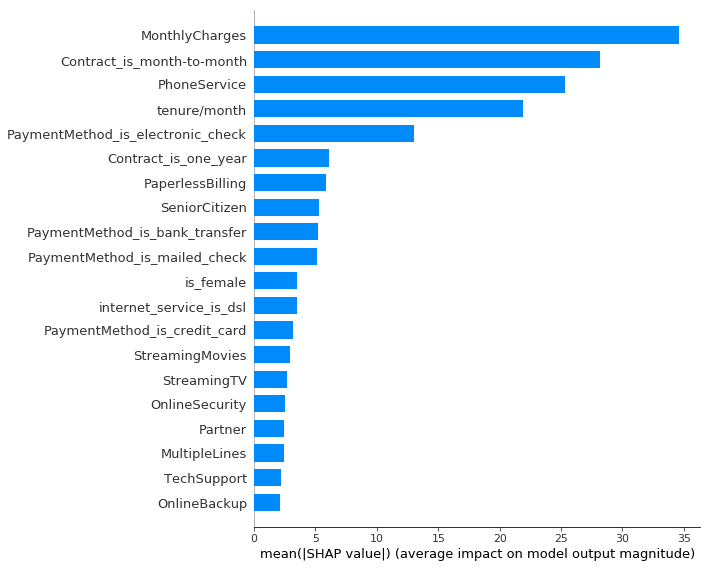

In [173]:
shap.summary_plot(shap_values, data_balanced_inputs, plot_type = 'bar')

How should we interpret this?

  1. The $y$ axis is as in the above beeswarm plot.
  
  2. The bars and the $x$ axis indicate the mean of the absolute values of the Shapley values of each observation. This is a measure of the overall feature importance across the dataset in terms of how it influences the model predictions.

From this most accurate classifier, we can see that the top few most important features from SHAP are (e.g.):

  * The amount the customer is charged per month (red to the right from the beeswarm plot means this feature increases churn)
  
  * Whether the customer contract is monthly (increases churn)
  
  * How long the customer tenure has been with the company in months (decreases churn)
  
  * Whether the payment is by electronic check (drives churn up).

Note that these features may change slightly given how we have down / upsampled the data or set the various random states.

Therefore, the strongest risk factors FOR churn include whether the customer is on short-term (i.e. monthly) contracts, how much they are charged, and (perhaps surprisingly) whether the payment method is by electronic check. Protector factors AGAINST churn include how long the customer has been with the company.

# Business Implications

On the basis of the above information, to minimise customer churn on the basis of the most accurate model, we can:

  1. Focus on bringing more customers from short-term to longer-term contracts, e.g. by making shorter-term contracts more expensive within reason, or making longer-term contracts cheaper.

  2. Reward long-term customers, e.g. those with longer tenure and those holding two-year contracts, to minimise churn, e.g. offer various complimentary services or partner with other businesses to give discounts on other goods.
  
  3. Ensure that prices are competitive given competing businesses, and emphasise that electronic checks are convenient and secure as a method of payment.
  
  4. Ensure that the business' services are of a very high quality.

# Conclusions

We have written three notebooks (including this one) to:

  1. Get the data and clean it by ensuring all features are represented numerically and there are no missing values.
  
  2. Visualise and analyse this data for multicollinearity and imbalanced classes.
  
  3. Model this data with a range of machine learning models (see above), adjust their hyperparameters over a development set, and did a final evaluation over the test set. We took the most accurate such model and used SHAP tp explain which features are important.

These activities have been motivated by two questions:

  1. How can we accurately model customer churn?
  
  2. What are the important features that one should consider for customer retention?
  
This notebook has answered both of these questions.

  1. We can accurately model customer churn by comparing a range of machine learning models and adjusting their hyperparameters to be their best at classifying churn on this dataset. However, the choice of models we have considered: logistic regression, decision trees, random forests, gradient boosted trees and support vector machines. The best models' accuracies are as follows:

In [174]:
final_results[['model', 'accuracy', 'F1']].reset_index(drop = True)

,model,accuracy,F1
0,gradient_boosting_1000_trees_depth_14_learning...,0.953661,0.956822
1,random_forest_10000_trees_depth_15,0.893420,0.906122
2,decision_tree_max_depth_20,0.885079,0.898858
3,logistic_regression_newton-cg_C_10.0,0.776645,0.792777
4,SVM_regularisation_1000.0_kernel_rbf_degree_3,0.775718,0.794218


  2. We can use the SHAP module to calculate Shapley values of each feature used by the most accuracy of the above models, and find that the most important factors influencing churn (perhaps unsurprisingly) are customers who are on short-term contracts and who are charged a lot, while the most important factors resisting churn are customers who use more services, customers who are on longer-term contracts and customers who have been with the company for longer. The business who wants to minimise churn can disincentivise customers to go on monthly contracts, e.g. by raising prices within reason, and focus on loyal customers who have been using the services for a long time.

In [175]:
"Notebook done in " + str(datetime.timedelta(seconds=time.time() - START)) + "."

'Notebook done in 1:46:20.096134.'